In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from backend import *

In [2]:
summaryDict = {"network":[],"all_srlg":[], "usable_srlg":[], "usable_srgl_above_th":[], "remained_usable_srlg_pct":[], "th":[], "th_mod":[], "base_edgeNum":[], "above_th_edgeNum":[]}
allDf = {}

for network in ["italy_995", "germany", "usa_995", "cost266"]:
    for th_mod in np.arange(0, 1.1, 0.1):
        srlgs, srlg_probs = get_SRLGs(f'../PSRLGs/{network}.xml')
        srlg_probs = np.asarray(srlg_probs)
        srlg_lengths = np.asarray([len(srlg) for srlg in srlgs])

        g_base = nx.read_gml(f'../networks/{network}.gml', label="id")
        g_base_pos = {node:(g_base.nodes[node]['Longitude'], g_base.nodes[node]['Latitude']) for node in g_base.nodes}
        if network == "italy_995":
            g_base.remove_edges_from([(19, 21, 1)])

        base_graph_numof_edges = g_base.number_of_edges()

        srlg_desc = {"idx":[], "edgeNum":[], "prob":[], "connected":[], "diameter":[], "usable":[]}
        for i,val in enumerate(srlgs):
            srlg_desc["idx"].append(i)
            srlg_desc["edgeNum"].append(len(val))
            srlg_desc["prob"].append(srlg_probs[i])

            subG = nx.Graph([s[:2] for s in srlgs[i]])
            connected = nx.is_connected(subG)

            srlg_desc["connected"].append(connected)
            if connected:
                srlg_desc["diameter"].append(nx.diameter(subG))
            else:
                cc = nx.connected_components(subG)
                S = [subG.subgraph(c).copy() for c in cc]
                biggest_cc_dia = max([nx.diameter(i) for i in S])
                srlg_desc["diameter"].append(1000)

            if (srlg_desc["connected"][-1] == True) & (srlg_desc["diameter"][-1] <= 2):
                srlg_desc["usable"].append(True)
            else:
                srlg_desc["usable"].append(False)

        srlgDf = pd.DataFrame(srlg_desc)
        highest_bad = srlgDf.query("usable == False").sort_values("prob", ascending=False).iloc[0]["prob"] * th_mod
        srlgDf["above_th"] = srlgDf["prob"].apply(lambda x: True if x > highest_bad else False)
        
        srlgDf.sort_values("prob", ascending=False).to_excel(f"../{network}_ordered_srlgs.xlsx", index=False)

        srlgIndexList = srlgDf.query("usable == True & above_th == True")["idx"].to_list()
        above_th_numof_edges = set()
        for i in srlgIndexList:
            if len(srlgs[i]) <= 2:
                above_th_numof_edges = above_th_numof_edges.union(srlgs[i])
            else:
                continue

        if th_mod == 1:
            allDf.update({network:srlgDf})

        summaryDict["network"].append(network)
        summaryDict["all_srlg"].append(len(srlgDf))
        summaryDict["usable_srlg"].append(sum(srlgDf["usable"]))
        usable_above_th = sum(srlgDf[["usable","above_th"]].sum(axis =1) == 2)
        summaryDict["usable_srgl_above_th"].append(usable_above_th)
        summaryDict["remained_usable_srlg_pct"].append(usable_above_th / sum(srlgDf["usable"]) * 100)
        summaryDict["th"].append(highest_bad)
        summaryDict["th_mod"].append(th_mod)
        summaryDict["base_edgeNum"].append(base_graph_numof_edges)
        summaryDict["above_th_edgeNum"].append(len(above_th_numof_edges))
        

summaryDf = pd.DataFrame(summaryDict)
summaryDf["remained_edge_pct"] = summaryDf["above_th_edgeNum"] / summaryDf["base_edgeNum"] * 100

In [3]:
summaryDf.query("th_mod == 0")

,network,all_srlg,usable_srlg,usable_srgl_above_th,remained_usable_srlg_pct,th,th_mod,base_edgeNum,above_th_edgeNum,remained_edge_pct
0,italy_995,11929,156,156,100.0,0.0,0.0,34,34,100.0
11,germany,4287,224,224,100.0,0.0,0.0,88,55,62.5
22,usa_995,750,254,254,100.0,0.0,0.0,42,42,100.0
33,cost266,5637,289,289,100.0,0.0,0.0,57,57,100.0


In [4]:
summaryDf.query("th_mod == 1")

,network,all_srlg,usable_srlg,usable_srgl_above_th,remained_usable_srlg_pct,th,th_mod,base_edgeNum,above_th_edgeNum,remained_edge_pct
10,italy_995,11929,156,43,27.564103,0.001707,1.0,34,25,73.529412
21,germany,4287,224,102,45.535714,0.000006,1.0,88,26,29.545455
32,usa_995,750,254,49,19.291339,0.000200,1.0,42,23,54.761905
43,cost266,5637,289,120,41.522491,0.000007,1.0,57,51,89.473684


In [5]:
summaryDf.sort_values(["network","th_mod"], ascending=False)

,network,all_srlg,usable_srlg,usable_srgl_above_th,remained_usable_srlg_pct,th,th_mod,base_edgeNum,above_th_edgeNum,remained_edge_pct
32,usa_995,750,254,49,19.291339,1.999016e-04,1.0,42,23,54.761905
31,usa_995,750,254,53,20.866142,1.799114e-04,0.9,42,26,61.904762
30,usa_995,750,254,54,21.259843,1.599213e-04,0.8,42,26,61.904762
29,usa_995,750,254,54,21.259843,1.399311e-04,0.7,42,26,61.904762
28,usa_995,750,254,59,23.228346,1.199409e-04,0.6,42,30,71.428571
27,usa_995,750,254,63,24.803150,9.995079e-05,0.5,42,33,78.571429
26,usa_995,750,254,65,25.590551,7.996063e-05,0.4,42,34,80.952381
25,usa_995,750,254,67,26.377953,5.997047e-05,0.3,42,34,80.952381
24,usa_995,750,254,127,50.000000,3.998032e-05,0.2,42,37,88.095238
23,usa_995,750,254,166,65.354331,1.999016e-05,0.1,42,40,95.238095


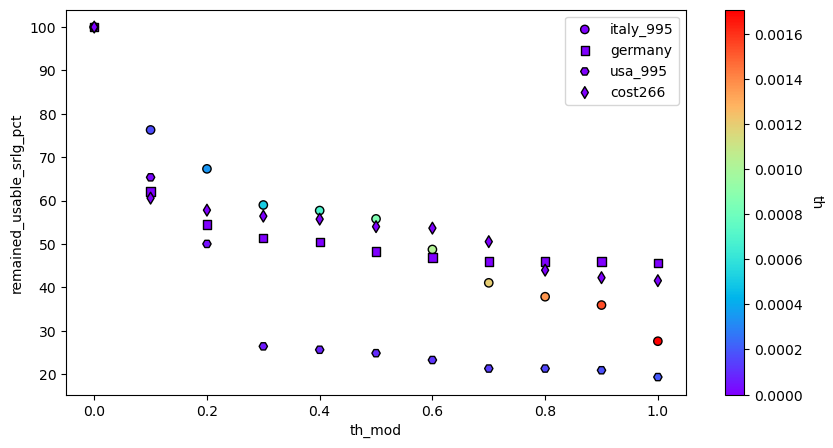

In [6]:
markers = ["o", "s", "H", "d"]
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=plt.Normalize(vmin=summaryDf["th"].min(), vmax=summaryDf["th"].max()))
x = "th_mod"
y = "remained_usable_srlg_pct"
c = "th"

fig, ax = plt.subplots(figsize = (10,5))
for i,n in enumerate(summaryDf["network"].unique()):
    filter_n = summaryDf["network"] == n
    ax.scatter(data=summaryDf[filter_n], x = x, y = y, c= c , marker=markers[i], cmap="rainbow", edgecolors="black", vmin=summaryDf["th"].min(), vmax=summaryDf["th"].max(), label = n)
plt.xlabel(x)
plt.ylabel(y)
cbar = plt.colorbar(sm, ax = ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(c, rotation=270)
plt.legend()
plt.show()

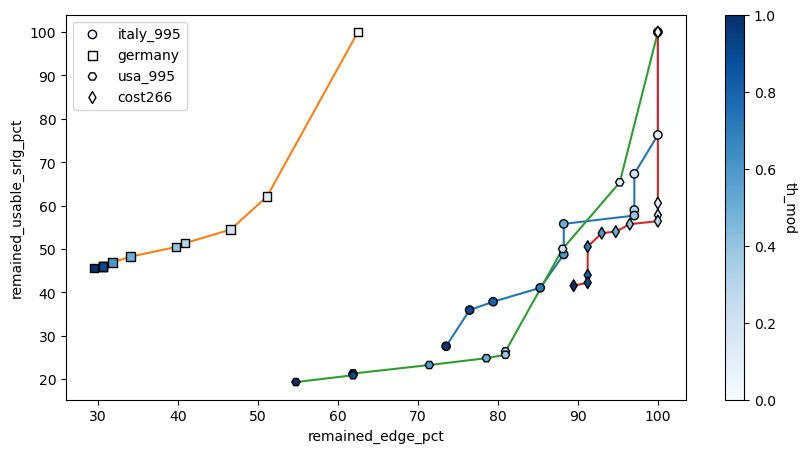

In [7]:
markers = ["o", "s", "H", "d"]
x = "remained_edge_pct"
y = "remained_usable_srlg_pct"
c = "th_mod"
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=summaryDf[c].min(), vmax=summaryDf[c].max()))

fig, ax = plt.subplots(figsize = (10,5))
for i,n in enumerate(summaryDf["network"].unique()):
    filter_n = summaryDf["network"] == n
    ax.plot(summaryDf[filter_n][x], summaryDf[filter_n][y], zorder = 1)
    ax.scatter(data=summaryDf[filter_n], x = x, y = y, c= c , marker=markers[i], cmap="Blues", edgecolors="black", vmin=summaryDf[c].min(), vmax=summaryDf[c].max(), zorder = 2, label = n)
plt.xlabel(x)
plt.ylabel(y)
cbar = plt.colorbar(sm, ax = ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(c, rotation=270)
plt.legend()
plt.show()

# Are edge nodes orderd in all srlg?

In [2]:
for network in ["italy_995", "germany", "usa_995", "cost266"]:
    srlgs, srlg_probs = get_SRLGs(f'../PSRLGs/{network}.xml')

    unique_srlgs = set()
    for i in srlgs:
        unique_srlgs.update(i)

    for i in unique_srlgs:
        if i[0] > i[1]:
            print(f"Ez nem jó!! {i}")